In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pandas.core.api import value_counts
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold,GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve, auc
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
df.isnull().sum()

,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


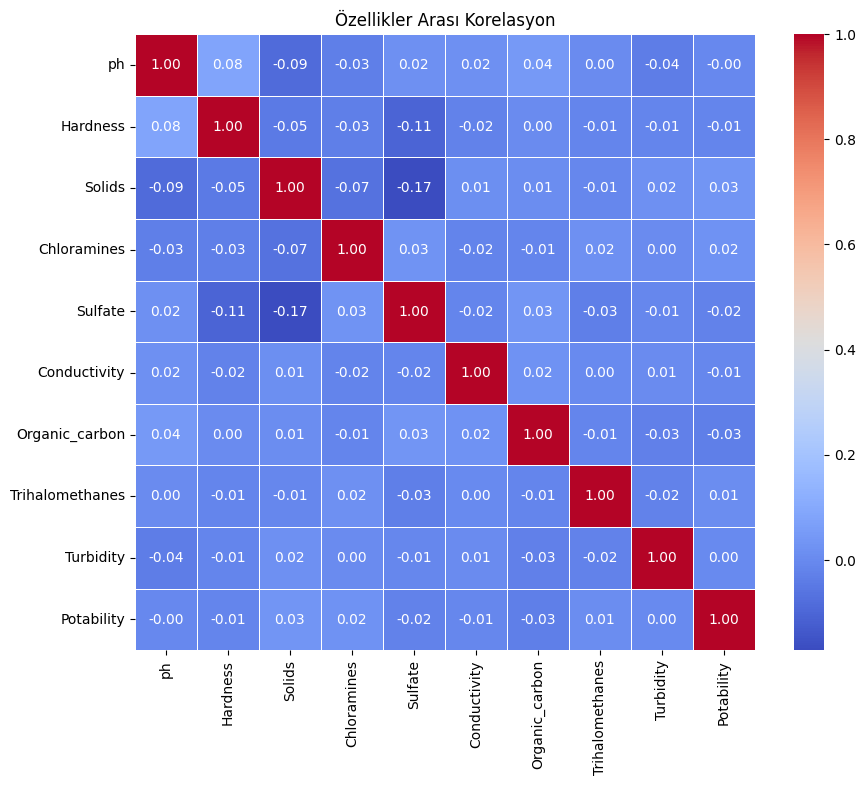

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Özellikler Arası Korelasyon')
plt.show()

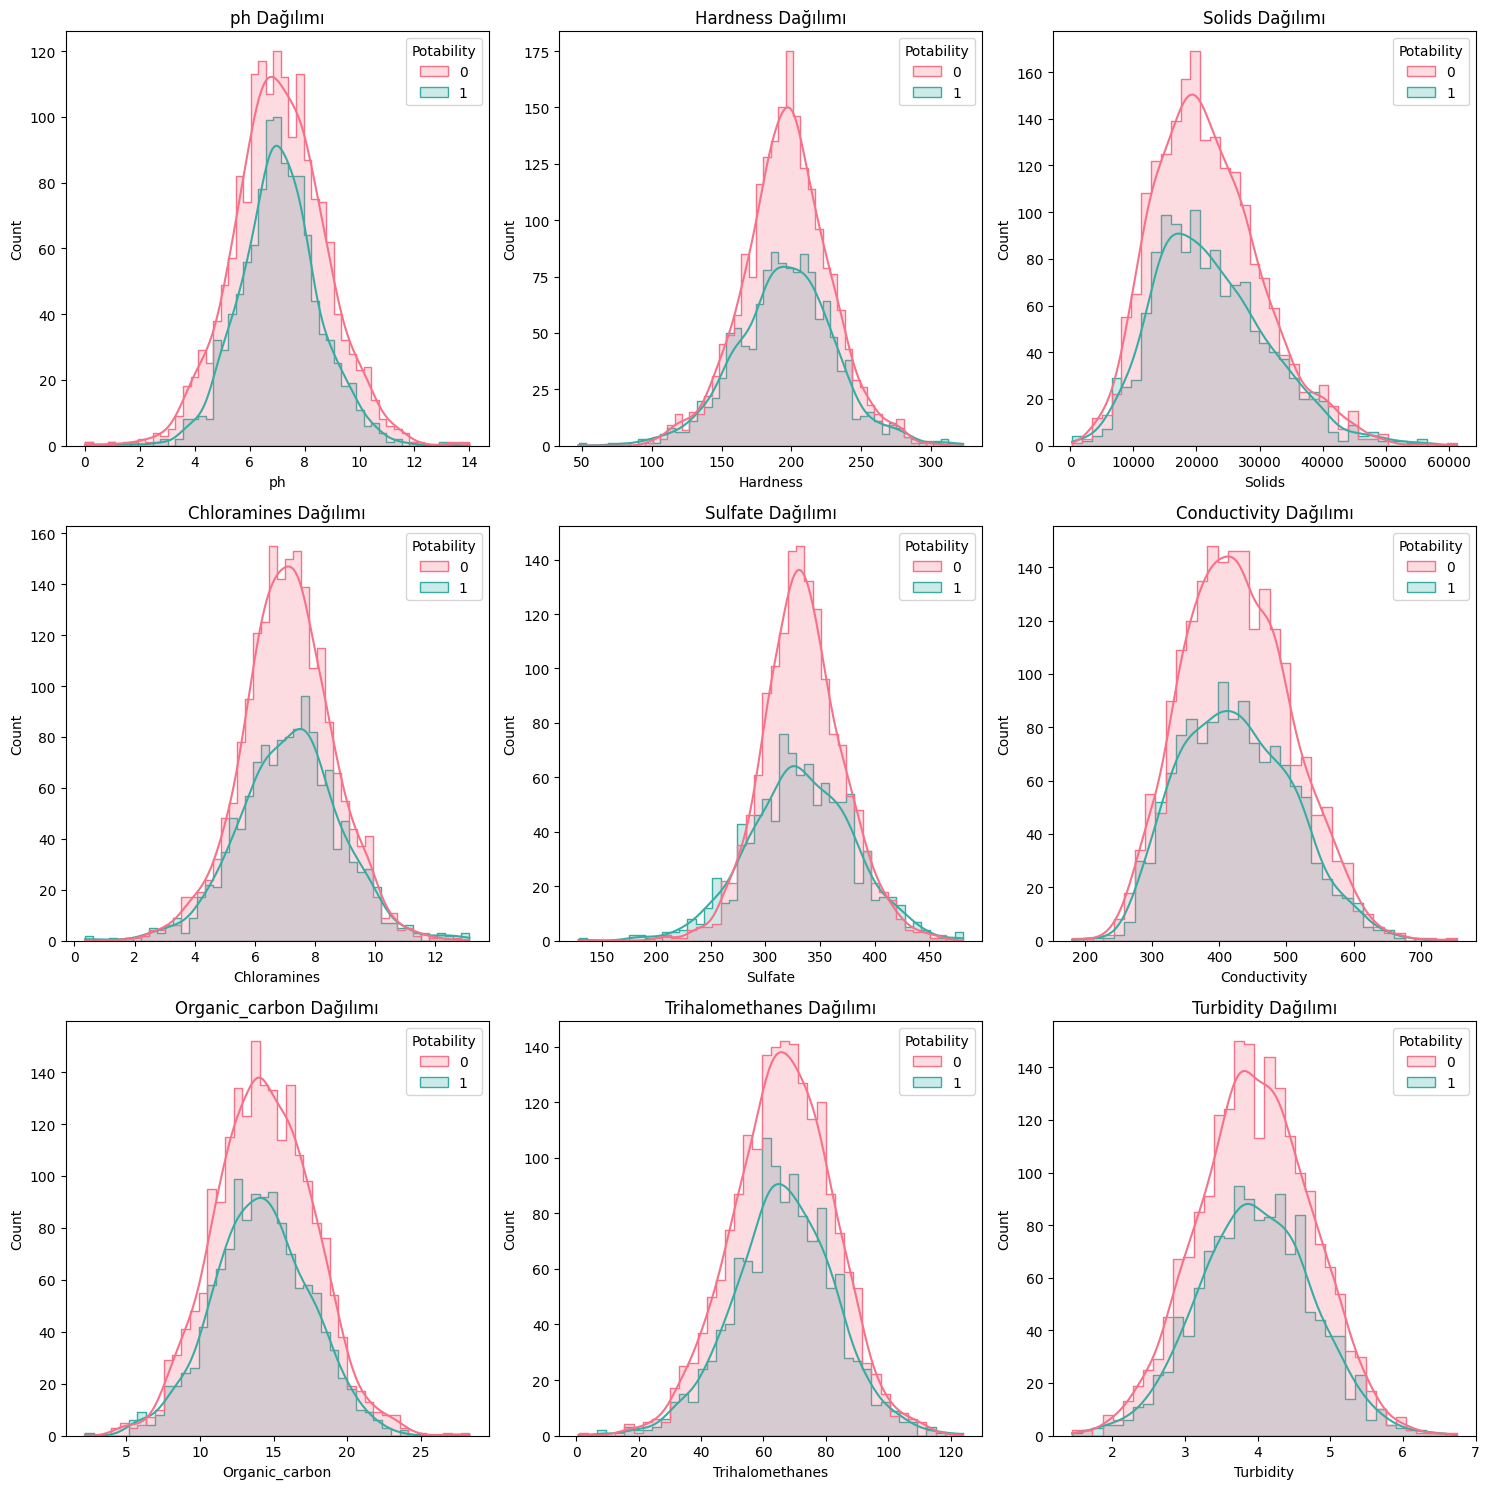

In [7]:
cols = df.drop('Potability', axis=1).columns

plt.figure(figsize=(15, 15))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, hue='Potability', kde=True, element="step", palette='husl')
    plt.title(f'{col} Dağılımı')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2692606479.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Potability', data=df, palette='viridis')


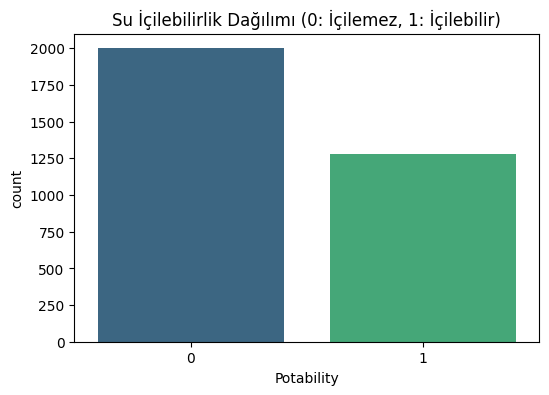

Potability
0    61%
1    39%
Name: proportion, dtype: object


In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Potability', data=df, palette='viridis')
plt.title('Su İçilebilirlik Dağılımı (0: İçilemez, 1: İçilebilir)')
plt.show()

print((df['Potability'].value_counts(normalize=True).map("{:.0%}".format)))

In [9]:
X = df.drop('Potability', axis=1)
y = df['Potability']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

imputer = KNNImputer(n_neighbors=5)
X_imputed_scaled = imputer.fit_transform(X_scaled)

df_features_final = pd.DataFrame(X_imputed_scaled, columns=X.columns)

df_final = pd.concat([df_features_final, y], axis=1)

print("Kalan boş değer:", df_final.isnull().sum().sum())
print("İlk 5 satır (Scaled):")
df_final.head()

Kalan boş değer: 0
İlk 5 satır (Scaled):


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,-0.316073,0.259195,-0.139471,0.112415,0.838973,1.708954,-1.180651,1.273445,-1.286298,0
1,-2.110818,-2.036414,-0.385987,-0.307694,0.380060,2.062575,0.270597,-0.622493,0.684218,0
2,0.638838,0.847665,-0.240047,1.360594,-0.252100,-0.094032,0.781117,0.001472,-1.167365,0
3,0.775374,0.547651,0.000493,0.592008,0.558106,-0.778830,1.255134,2.098969,0.848412,0
4,1.261849,-0.464429,-0.460249,-0.363698,-0.570898,-0.343939,-0.824357,-2.126974,0.138786,0


In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    df_final.drop("Potability", axis=1),
    df_final["Potability"],
    test_size=0.2,
    random_state=42,
    stratify=df_final["Potability"]
)
print(f"SMOTE Öncesi Train Seti Dağılımı:\n{y_train.value_counts()}")

smote=SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
print(f"\nSMOTE Sonrası Train Seti Dağılımı:\n{y_train_resampled.value_counts()}")

SMOTE Öncesi Train Seti Dağılımı:
Potability
0    1598
1    1022
Name: count, dtype: int64

SMOTE Sonrası Train Seti Dağılımı:
Potability
0    1598
1    1598
Name: count, dtype: int64


Fitting 3 folds for each of 144 candidates, totalling 432 fits

Bulunan En İyi Parametreler: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       400
           1       0.54      0.51      0.52       256

    accuracy                           0.64       656
   macro avg       0.62      0.61      0.61       656
weighted avg       0.63      0.64      0.64       656

Random Forest Doğruluk (Accuracy): %63.72


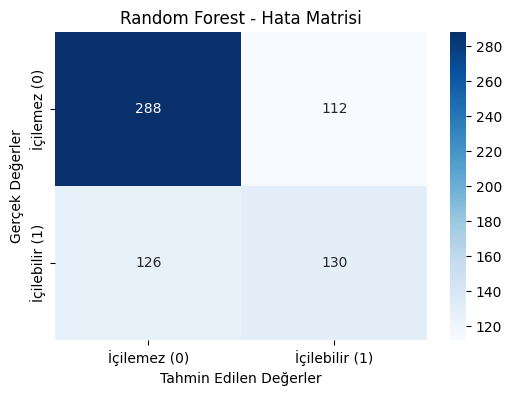

In [11]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 10, 12, 15],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)
best_rf_model = grid_search.best_estimator_
print(f"\nBulunan En İyi Parametreler: {grid_search.best_params_}")

y_pred_tuned = best_rf_model.predict(x_test)
print(classification_report(y_test, y_pred_tuned))
print(f"Random Forest Doğruluk (Accuracy): %{accuracy_score(y_test, y_pred_tuned) * 100:.2f}")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test,y_pred_tuned), annot=True, fmt='d',cmap='Blues',
            xticklabels=['İçilemez (0)','İçilebilir (1)'],
            yticklabels=['İçilemez (0)','İçilebilir (1)'])
plt.title('Random Forest - Hata Matrisi')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
En İyi Parametreler: {'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 10, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 1, 'colsample_bytree': 0.7}

 Final Rapor
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       400
           1       0.52      0.55      0.53       256

    accuracy                           0.62       656
   macro avg       0.61      0.61      0.61       656
weighted avg       0.63      0.62      0.63       656

XGBoost Doğruluk (Accuracy): %62.50


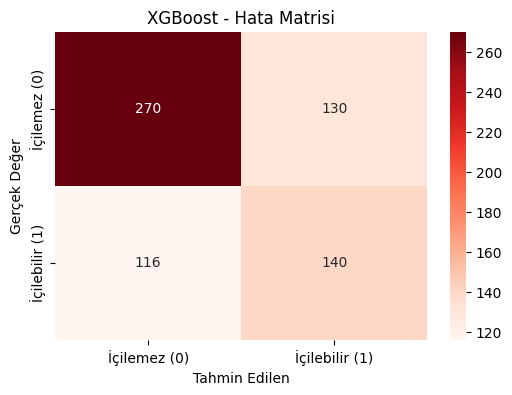

In [12]:
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'scale_pos_weight': [1],
    'min_child_weight': [3, 5, 7],
    'reg_lambda': [10, 20, 50, 100],
    'gamma': [1, 2, 5]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params,
    n_iter=20,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_resampled, y_train_resampled)
print(f"En İyi Parametreler: {random_search.best_params_}")
best_model = random_search.best_estimator_
y_pred_final = best_model.predict(x_test)

print("\n Final Rapor")
print(classification_report(y_test, y_pred_final))
print(f"XGBoost Doğruluk (Accuracy): %{accuracy_score(y_test, y_pred_final) * 100:.2f}")
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['İçilemez (0)', 'İçilebilir (1)'],
            yticklabels=['İçilemez (0)', 'İçilebilir (1)'])

plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.title('XGBoost - Hata Matrisi')
plt.show()

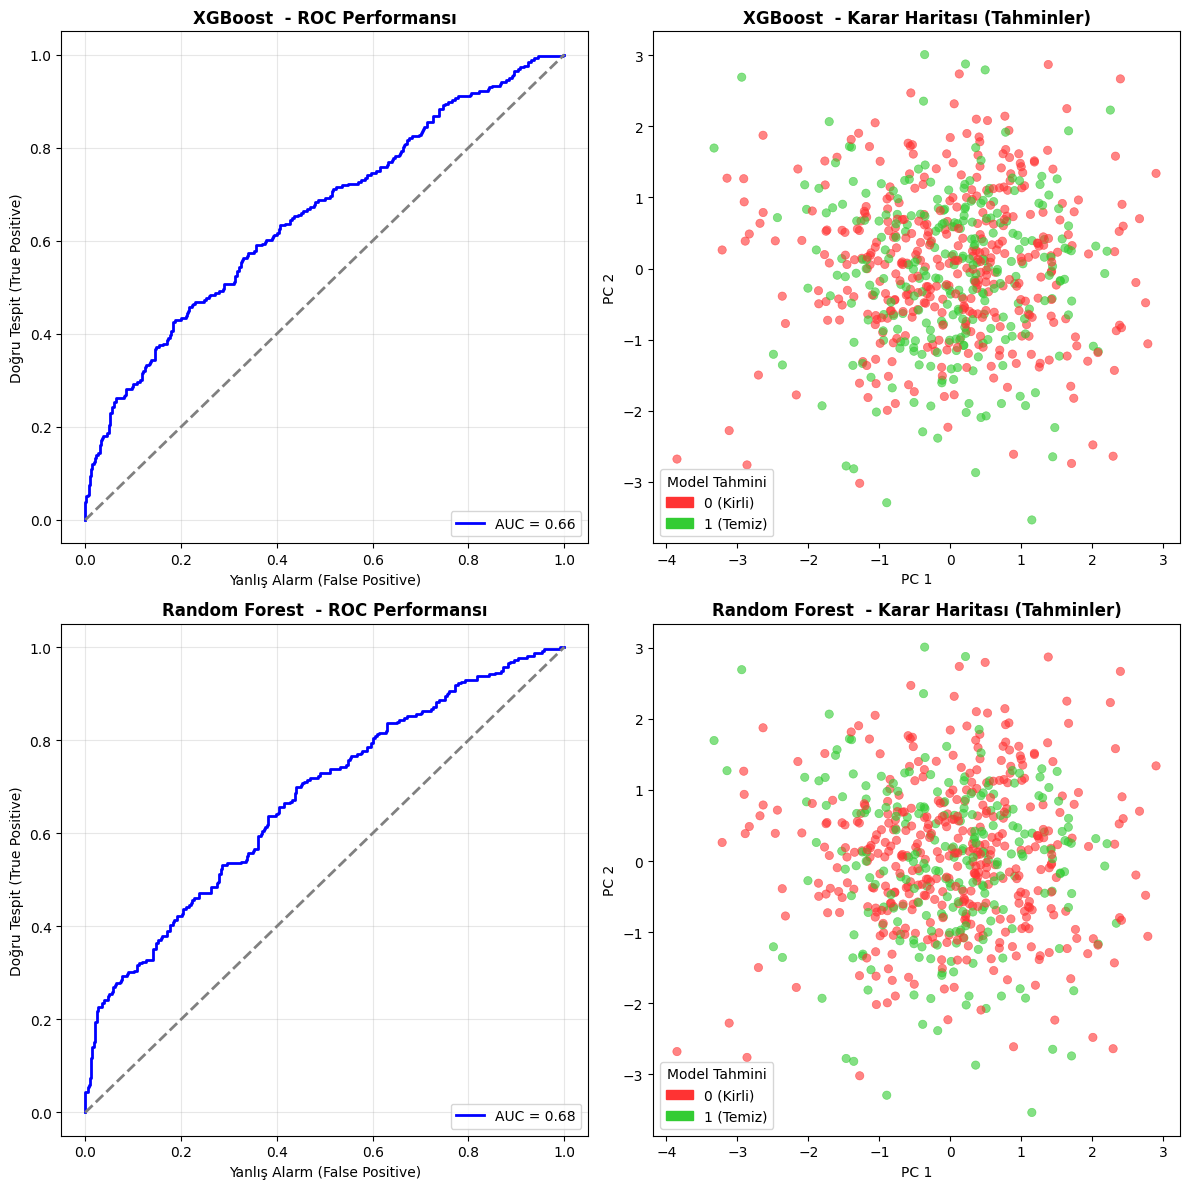

In [13]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(x_test)


models_setup = [
    ("XGBoost ", best_model, x_test),
    ("Random Forest ", best_rf_model, x_test),
]

# Grafik Alanı
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)
colors = {0: '#FF3333', 1: '#33CC33'}

for i, (name, model, data) in enumerate(models_setup):

    # --- TAHMİNLER ---
    y_pred = model.predict(data)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(data)[:, 1]
    else:
        y_proba = model.decision_function(data)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    # --- SOL GRAFİK: ROC CURVE ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax_roc = axes[i, 0]
    ax_roc.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_title(f'{name} - ROC Performansı', fontsize=12, fontweight='bold')
    ax_roc.set_xlabel('Yanlış Alarm (False Positive)')
    ax_roc.set_ylabel('Doğru Tespit (True Positive)')
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True, alpha=0.3)

    # --- SAĞ GRAFİK: PCA KARAR HARİTASI ---
    ax_pca = axes[i, 1]
    plot_colors = [colors[label] for label in y_pred]

    sns.scatterplot(
        x=X_test_pca[:, 0],
        y=X_test_pca[:, 1],
        c=plot_colors,
        alpha=0.6,
        edgecolor=None,
        ax=ax_pca
    )
    legend_handles = [
        mpatches.Patch(color=colors[0], label='0 (Kirli)'),
        mpatches.Patch(color=colors[1], label='1 (Temiz)')
    ]
    ax_pca.set_title(f'{name} - Karar Haritası (Tahminler)', fontsize=12, fontweight='bold')
    ax_pca.set_xlabel('PC 1')
    ax_pca.set_ylabel('PC 2')
    ax_pca.legend(handles=legend_handles, title='Model Tahmini')

plt.tight_layout()
plt.show()

En Önemsiz Özellikler:
Trihalomethanes    0.089704
Turbidity          0.090385
Organic_carbon     0.091251
Conductivity       0.096788
Hardness           0.113280
Solids             0.119140
Chloramines        0.127523
ph                 0.131754
Sulfate            0.140175
dtype: float32


/tmp/ipython-input-795060726.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp, y=feature_imp.index, palette='Reds')


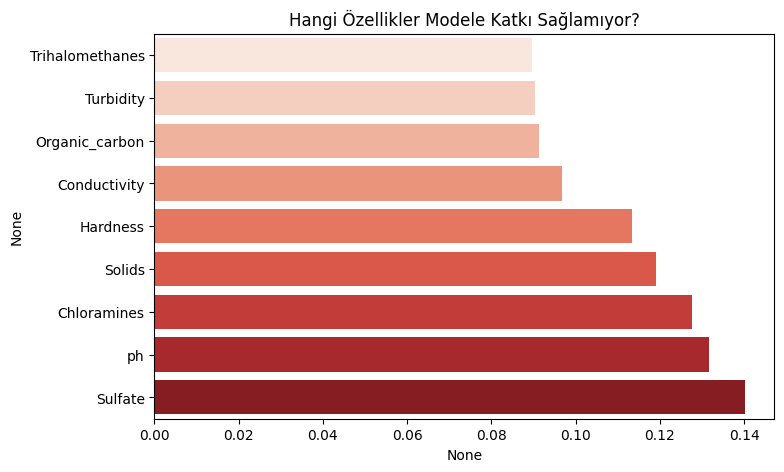

In [14]:
feature_imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=True)

print("En Önemsiz Özellikler:")
print(feature_imp)
plt.figure(figsize=(8,5))
sns.barplot(x=feature_imp, y=feature_imp.index, palette='Reds')
plt.title("Hangi Özellikler Modele Katkı Sağlamıyor?")
plt.show()